# **CO-FOREST - PRUEBAS** 

##### **Autora: Patricia Hernando Fernández**

---------------------------
### **IMPORTS**

In [15]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
import numpy as np
import numbers
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import csv
from itertools import cycle
import time

### **UTILS**

In [16]:
def append_to_csv(file, array):
    f = open( file, 'a')
    np.savetxt(f, array, fmt='%1.3f', newline=",")
    f.write("\n")
    f.close()


def read_irregular_csv(file):

    data = []

    with open(file) as csv_file:
        
        for row in csv.reader(csv_file):
            data.append([float(x) for x in row if x != ""])
        csv_file.close()

    return data

def create_graph_matrix(file):

    m = []
    l = read_irregular_csv(file)
    max_iters = max([[len(x)] for x in l])[0]

    for list in l:
        list = np.array(list)
        new = np.ones(shape = (max_iters)) * list[-1]
        i = np.arange(0, list.shape[0])
        new[i] = list[i]
        m.append(new)

    return np.array(m)

### **CLASS**

In [17]:
class Co_Forest:


    def __init__(self, L, y, U, n, theta, classes, random_state=None, max_features='log2',  X_test=None, y_test=None):

        self.random_state = self.check_random_state(random_state)
        self.n = n
        self.theta = theta
        self.classes = classes

        self.U = U
        self.L = L
        self.y = y
        self.mask_L = np.zeros(shape=((self.L.shape[0]), self.n), dtype=int, order='C')

        self.X_test = X_test #Se quitarán en la versión sin graphs
        self.y_test = y_test #Se quitarán en la versión sin graphs

        self.ensemble = self.create_trees(max_features)
        
    def create_trees(self, max_features) -> dict:

        ensemble = {}

        for i in range(self.n):

            rand_rows = self.random_state.choice(a = np.arange(start=0, stop=self.L.shape[0]), replace = True, size=(int(0.7*self.L.shape[0])) )
            self.mask_L[rand_rows, i] = 1
            h = DecisionTreeClassifier(max_features=max_features, random_state=self.random_state)
            ensemble[i] = h.fit(self.L[rand_rows, :], self.y[rand_rows])

        return ensemble

    def fit(self):

        if self.X_test is not None: #Se quitará en la versión sin graphs
            scores = [self.score(self.X_test, self.y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]
        previous_e = [0.5 for i in range(self.n)]
        previous_W = [min(0.1*len(self.L), 100) for i in range(self.n)]

        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * self.U.shape[0]
                    else:
                        Wmax = min(self.theta * self.U.shape[0], ((previous_e[i]*previous_W[i])/e[i]) )

                    U_subsampled = self.subsample(hi, Wmax) 
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(hi, self.U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(self.U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = ( (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags) ) )

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(i, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1])

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            if self.X_test is not None: #Se quitará en la versión sin graphs
                scores.append(self.score(self.X_test, self.y_test))

        if self.X_test is not None: #Se quitará en la versión sin graphs
            append_to_csv("file.csv", scores)
        
        
    def retrain_tree(self, i, pseudo_labeled_data, pseudo_labeled_tags):

        pseudo_labeled_data = (lambda x: np.expand_dims(x, axis=0) if x.ndim == 1 else x)(pseudo_labeled_data)
        X_train = np.concatenate( (self.L[self.mask_L[:, i] == 1], pseudo_labeled_data) )
        y_train = np.concatenate( (self.y[self.mask_L[:, i] == 1], pseudo_labeled_tags) )
        self.ensemble[i] = self.ensemble[i].fit(X_train, y_train)
        
    def subsample(self, hi: DecisionTreeClassifier, Wmax: float) -> np.array:

        W = 0
        U_subsampled = []

        while (W < Wmax):

            rand_row = self.random_state.choice(a = np.arange(start=0, stop=self.U.shape[0]))
            W += self.concomitant_confidence(hi, self.U[rand_row, :])[0]
            U_subsampled.append(rand_row)

        return np.array(U_subsampled)

        
    def concomitant_oob_error(self, hi: DecisionTreeClassifier) -> float:

        errors = []

        for sample, tag in zip(self.L, self.y):
            n_votes = 0
            n_hits = 0 

            for i, tree in self.ensemble.items():

                rows_training = self.L[self.mask_L[:, i] == 1]
                used_training = np.any(np.all(sample == rows_training, axis=1))

                if tree is not hi and not used_training:
                    if tree.predict([sample])[0] == tag:
                        n_hits += 1
                    n_votes +=1

            if (n_votes > 0):
                errors.append(1 - (n_hits/n_votes))

        return np.mean(a=errors)

    def concomitant_confidence(self, hi: DecisionTreeClassifier, sample: np.array) -> tuple:

        count = {i: 0  for i in self.classes}

        for tree in self.ensemble.values():
            if tree is not hi:
                count[tree.predict([sample])[0]] += 1

        max_agreement = max(count.values())
        most_agreed_class = list(count.keys())[list(count.values()).index(max_agreement)]

        return max_agreement/(len(self.ensemble) -1), most_agreed_class


    def single_predict(self, sample: np.array): 

        count = {i: 0  for i in self.classes}
        for i in (tree.predict([sample])[0] for tree in self.ensemble.values()):
            count[i]+= 1

        max_agreement = max(count.values())
        return list(count.keys())[list(count.values()).index(max_agreement)]


    def predict(self, samples: np.array) -> np.array:
        
        samples = (lambda x: np.expand_dims(x, axis=0) if x.ndim == 1 else x)(samples)
        return np.array([self.single_predict(sample) for sample in samples])


    def single_predict_proba(self, sample : np.array):

        count = {i: 0  for i in self.classes}

        for i in (tree.predict([sample])[0] for tree in self.ensemble.values()):
                count[i]+= 1

        votes = np.array(list(count.values()))
        return votes / self.n


    def predict_proba(self, samples: np.array):

        samples = (lambda x: np.expand_dims(x, axis=0) if x.ndim == 1 else x)(samples)
        return np.array([self.single_predict_proba(sample) for sample in samples])


    def score(self, X_test: np.array, y_test: np.array) -> float:
        y_predictions = self.predict(X_test)
        return np.count_nonzero(y_predictions==y_test)/len(y_test)

    def check_random_state(self, seed):

        if seed is None or seed is np.random:
            return np.random.mtrand._rand
        if isinstance(seed, numbers.Integral):
            return np.random.RandomState(seed)
        if isinstance(seed, np.random.RandomState):
            return seed
        raise ValueError("%r cannot be used to seed a numpy.random.RandomState instance" % seed)

# **GRAPHS & COMPARES**

In [11]:
# Against KEEL
def extract_training_data(csv):

    df = pd.read_csv(csv)

    caract_cols = df.columns
    X_y_all = df[caract_cols].values 

    L = X_y_all[X_y_all[:, -1] != -1]
    U = X_y_all[X_y_all[:, -1] == -1]

    L_tags = L[:, -1]
    L = L[:, :-1]
    U = U[:, :-1]

    return L, L_tags, U


def extract_test_data(csv):

    df = pd.read_csv(csv)

    caract_cols = df.columns
    X_y_all = df[caract_cols].values 

    y = X_y_all[:, -1]
    X = X_y_all[:, :-1]

    return X, y

l = []
for i in range(1, 11):

    # L, L_tags, U = extract_training_data("iris/{}f_tra.csv".format(i)) #5
    # X, y = extract_test_data("iris/{}f_tst.csv".format(i))

    L, L_tags, U = extract_training_data("wine/wine-ssl10-10-{}tra.csv".format(i)) #10
    X, y = extract_test_data("wine/wine-ssl10-10-{}tst.csv".format(i))

    co_forest = Co_Forest(L, L_tags, U, 6, 0.75, np.unique(L_tags), np.random.RandomState(10))
    co_forest.fit()
    l.append(co_forest.score(X, y))

print(l)
print(np.array(l).mean())

[0.8888888888888888, 1.0, 0.9444444444444444, 0.9444444444444444, 0.6470588235294118, 0.9411764705882353, 0.8333333333333334, 0.9444444444444444, 0.6666666666666666, 0.9444444444444444]
0.8754901960784313


### Variación Score - Número Iteraciones

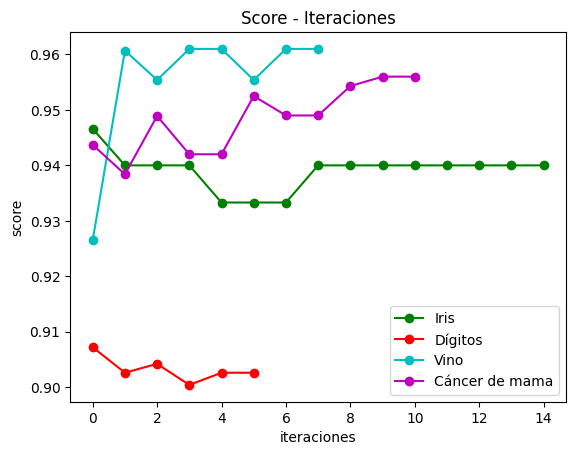

In [23]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)
    open('file.csv', 'w').close()

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        
        co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, available_classes, rd,'log2', X_test, y_test)
        co_forest.fit()

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    ax.plot(np.arange(len(mean)), mean, '-o', color = next(cycol), label = dataset_info[1])

#plt.title("Score - Iteraciones")
ax.set_ylabel('score')
ax.set_xlabel('iteraciones')
plt.legend(loc="lower right")
plt.show()

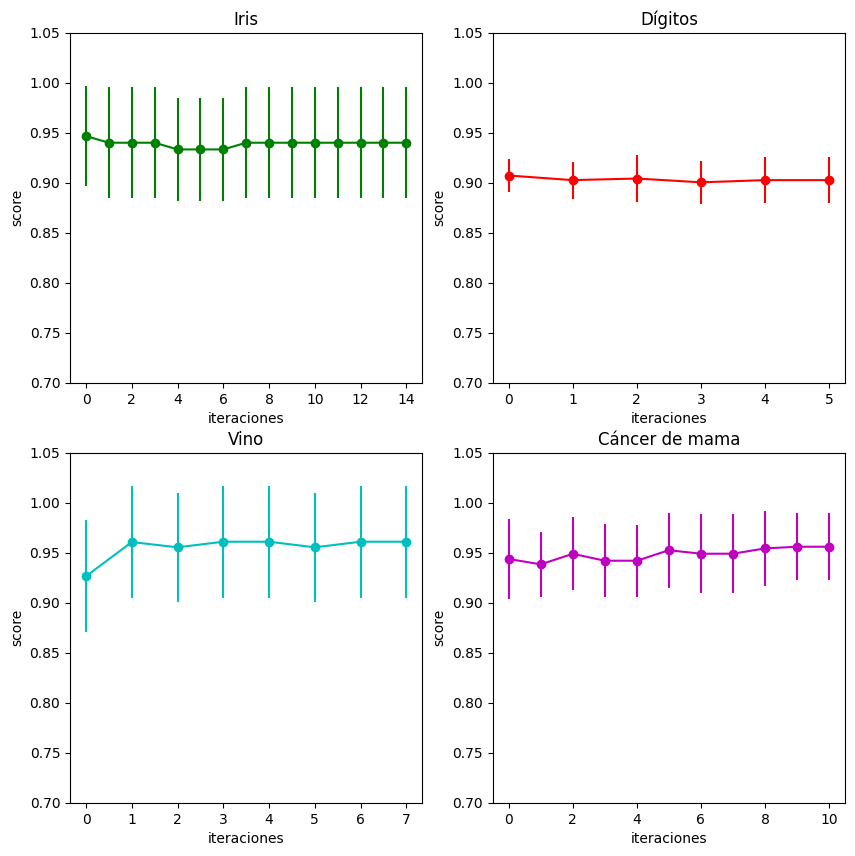

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris', (0,0)), (load_digits(), 'Dígitos', (0,1)), (load_wine(), 'Vino', (1,0)), (load_breast_cancer(), 'Cáncer de mama', (1,1))]

for dataset_info in available:

    open('file.csv', 'w').close()
    dataset = dataset_info[0]

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        
        co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, np.unique(dataset.target), rd,'log2', X_test, y_test)
        co_forest.fit()

    mean = np.mean(create_graph_matrix("file.csv"), axis=0)
    std = np.std(create_graph_matrix("file.csv"), axis=0)

    coordinates = dataset_info[2]
    ax_i = ax[coordinates[0], coordinates[1]]
    ax_i.set_ylim([0.7, 1.05])
    ax_i.errorbar(np.arange(len(mean)), mean, std, fmt='-o', color = next(cycol), label = dataset_info[1])
    ax_i.set_ylabel('score')
    ax_i.set_xlabel('iteraciones')
    ax_i.set_title(dataset_info[1])
    
plt.show()

### Número elementos - tiempo entrenamiento


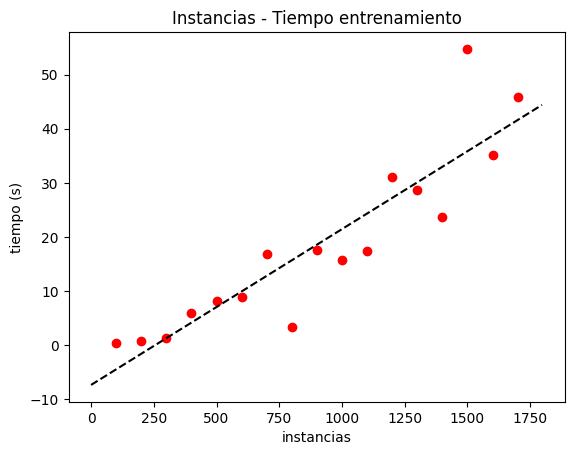

In [18]:
cycol = cycle('bgrcmk')
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
next(cycol) 

dataset_info = (load_digits(), 'Dígitos')
dataset = dataset_info[0]

instancias = []
tiempos = []
rd = np.random.RandomState(5)

for i in range(100, dataset.data.shape[0], 100):

    indexes = rd.choice(a = np.arange(start=0, stop=X.shape[0]), replace = True, size=i)
    X = np.array(dataset.data)[indexes]
    y = np.array(dataset.target)[indexes]
    L_train, U_train, Ly_train, Uy_train = train_test_split(X, y, test_size=0.8, random_state=rd)

    inicio = time.time()
    co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, np.unique(dataset.target), rd,'log2')
    co_forest.fit()
    fin = time.time()

    instancias.append(X.shape[0])
    tiempos.append((fin-inicio))

ax.scatter(instancias, tiempos, color=next(cycol) )

model = LinearRegression()
model.fit(np.array([[i] for i in instancias]), tiempos)
x_new = np.linspace(0, dataset.data.shape[0], 100)
y_new = model.predict(x_new[:, np.newaxis])

plt.title("Instancias - Tiempo entrenamiento")
ax.plot(x_new, y_new, '--k')
ax.set_xlabel('instancias')
ax.set_ylabel('tiempo (s)')
plt.show()

### Score - % Instancias entrenamiento

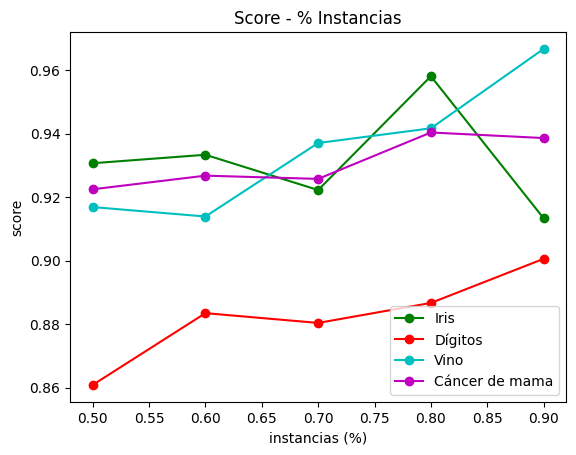

In [29]:
fig, ax = plt.subplots()
cycol = cycle('bgrcmk')
next(cycol)
rd = np.random.RandomState(5)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    matriz_scores = []
    dataset = dataset_info[0]
    
    for j in range(10): #Número de experimentos
        
        scores_experimento = []

        for i in np.arange(0.5, 1, 0.1):

            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=i, random_state=rd, stratify=dataset.target)
            L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            co_forest = Co_Forest(L_train, Ly_train, U_train, 20, 0.75, np.unique(dataset.target), rd,'log2')
            co_forest.fit()
            scores_experimento.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_experimento)

    ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0), '-o', color=next(cycol),  label=dataset_info[1])

plt.title("Score - % Instancias")
ax.set_ylabel('score')
ax.set_xlabel('instancias (%)')
plt.legend(loc="lower right")
plt.show()

## Score / nº árboles

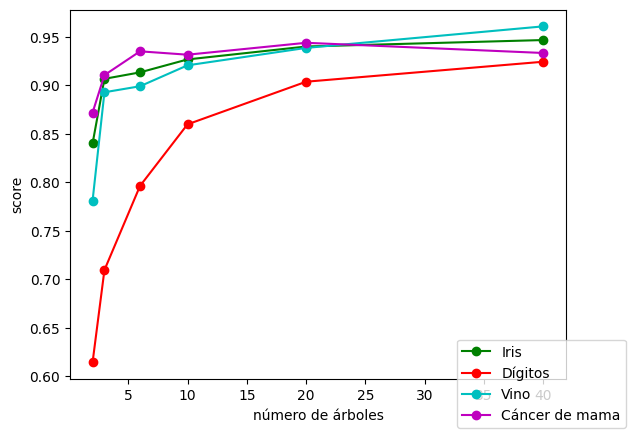

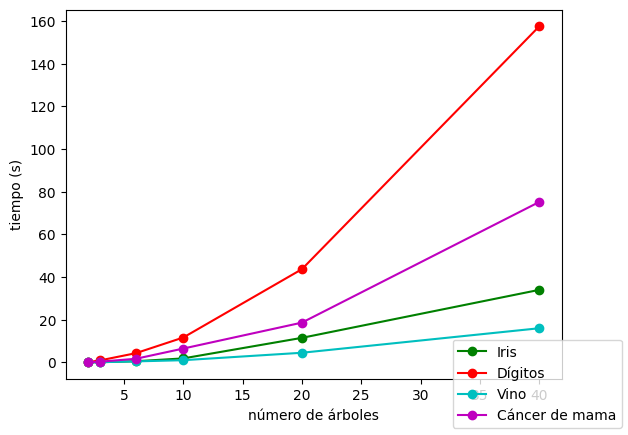

In [28]:
fig, ax = plt.subplots()
fig_2, ax_2 = plt.subplots()

cycol = cycle('bgrcmk')
next(cycol)
available = [(load_iris(), 'Iris'), (load_digits(), 'Dígitos'), (load_wine(), 'Vino'), (load_breast_cancer(), 'Cáncer de mama')]

for dataset_info in available:

    dataset = dataset_info[0]
    available_classes = np.unique(dataset.target)

    X = np.array(dataset.data)
    y = np.array(dataset.target)

    rd = np.random.RandomState(5)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    matriz_scores = []
    matriz_tiempos = []

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
        scores_fold = []
        times_fold = []
        
        for j in [2, 3, 6, 10, 20, 40]:
            co_forest = Co_Forest(L_train, Ly_train, U_train, j, 0.75, available_classes, rd,'log2')
            inicio = time.time()
            co_forest.fit()
            fin = time.time()
            times_fold.append((fin-inicio))
            scores_fold.append(co_forest.score(X_test, y_test))

        matriz_scores.append(scores_fold)
        matriz_tiempos.append(times_fold)

    c = next(cycol)
    ax.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_scores), axis=0), '-o', color=c,  label=dataset_info[1])
    ax_2.plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(matriz_tiempos), axis=0), '-o', color=c,  label=dataset_info[1])

#plt.title("Score - Número de árboles")
ax.set_ylabel('score')
ax.set_xlabel('número de árboles')
fig.legend(loc="lower right")

ax_2.set_ylabel('tiempo (s)')
ax_2.set_xlabel('número de árboles')
fig_2.legend(loc="lower right")

plt.show()